In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models
%matplotlib inline

In [2]:
transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
# torch.manual_seed(0)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(0)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
train_directory = 'data\\5_classes\\train'
test_directory = 'data\\5_classes\\test'

trainset = datasets.ImageFolder(root=train_directory, transform=transform)
testset = datasets.ImageFolder(root=test_directory, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=120, shuffle=True)

train_data_size = len(trainset)
test_data_size = len(testset)

In [5]:
class_idx_map = dict(zip(range(len(trainset.classes)), trainset.classes))

In [6]:
resnet50 = models.resnet50(pretrained=True)

In [7]:
for param in resnet50.parameters():
    param.requires_grad = False

In [8]:
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 5), 
    nn.Softmax(dim=1) # For using NLLLoss()
)

In [9]:
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)

In [10]:
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
import time
start_time = time.time()
for epoch in range(10): 
    for data in trainloader: 
        X, y = data
        X, y = X.to(device), y.to(device)
        resnet50.zero_grad()  
        output = resnet50(X)
        loss = F.cross_entropy(output, y)  
        loss.backward()  
        optimizer.step() 
    print("epoch", epoch, "  ", loss)
end_time = time.time()
print("Training completed in: ", end_time-start_time, " sec")

epoch 0    tensor(1.1808, device='cuda:0', grad_fn=<NllLossBackward>)
epoch 1    tensor(1.1973, device='cuda:0', grad_fn=<NllLossBackward>)
epoch 2    tensor(1.1253, device='cuda:0', grad_fn=<NllLossBackward>)
epoch 3    tensor(0.9971, device='cuda:0', grad_fn=<NllLossBackward>)
epoch 4    tensor(1.0173, device='cuda:0', grad_fn=<NllLossBackward>)
epoch 5    tensor(1.0157, device='cuda:0', grad_fn=<NllLossBackward>)
epoch 6    tensor(0.9926, device='cuda:0', grad_fn=<NllLossBackward>)
epoch 7    tensor(1.1997, device='cuda:0', grad_fn=<NllLossBackward>)
epoch 8    tensor(0.9597, device='cuda:0', grad_fn=<NllLossBackward>)
epoch 9    tensor(1.0311, device='cuda:0', grad_fn=<NllLossBackward>)
Training completed in:  1452.7460961341858  sec


In [15]:
confusion_matrix = {0:[0,0,0,0,0],1:[0,0,0,0,0],2:[0,0,0,0,0],3:[0,0,0,0,0],4:[0,0,0,0,0]}
mislead = {0:[0,0,0,0,0],1:[0,0,0,0,0],2:[0,0,0,0,0],3:[0,0,0,0,0],4:[0,0,0,0,0]}
mislead_idx = []
with torch.no_grad():
    for data in testloader:
        X, y = data
        X, y = X.to(device), y.to(device)
        output = resnet50(X)
#         print(output)
        for idx, i in enumerate(output):
#             print(torch.argmax(i))
            for key in confusion_matrix:
                if y[idx] == key:
                    if torch.max(i)>0.65:
                        confusion_matrix[key][torch.argmax(i)] += 1
                    else:
                        confusion_matrix[key][torch.argmax(i)] += 1
                        mislead[key][torch.argmax(i)] += 1
                        mislead_idx.append([torch.argmax(i), y[idx], X[idx]])
#         break

In [16]:
class_idx_map = dict(zip(range(len(trainset.classes)), trainset.classes))
accuracy = {}
total = 0
slack = 0
for key in confusion_matrix:
    accuracy[key] = round(confusion_matrix[key][key]/sum(confusion_matrix[key]), 3)
for key in confusion_matrix:
    total += sum(confusion_matrix[key])
    slack += confusion_matrix[key][key]
accuracy['over_all'] = round(slack/total, 3)
print('total=', total)
print("confusion matrix: ", confusion_matrix)
print("mislead: ", mislead)
print("accuracy: ", accuracy)
print("mapping: ", class_idx_map)

total= 351
confusion matrix:  {0: [64, 5, 0, 1, 0], 1: [13, 55, 1, 1, 0], 2: [6, 17, 45, 3, 0], 3: [1, 3, 0, 66, 0], 4: [0, 0, 0, 0, 70]}
mislead:  {0: [2, 3, 0, 0, 0], 1: [1, 5, 1, 0, 0], 2: [3, 2, 7, 0, 0], 3: [0, 0, 0, 1, 0], 4: [0, 0, 0, 0, 0]}
accuracy:  {0: 0.914, 1: 0.786, 2: 0.634, 3: 0.943, 4: 1.0, 'over_all': 0.855}
mapping:  {0: 'aadhaar_b', 1: 'aadhaar_f', 2: 'company_id', 3: 'pan', 4: 'profile_pic'}


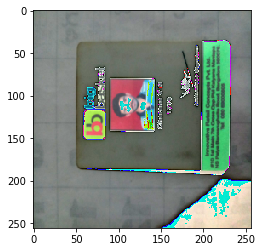

In [32]:
index = 5
plt.imshow((transforms.ToPILImage()((mislead_idx[index][2]).cpu())), interpolation='nearest')
# {0: 'aadhaar_b', 1: 'aadhaar_f', 2: 'company_id', 3: 'pan', 4: 'profile_pic'}

In [14]:
torch.save(resnet50.state_dict(), '5_classes.pt')

In [ ]:
resnet50.load_state_dict(torch.load('5_classes.pt', map_location=lambda storage, loc: storage))
resnet50.eval()

In [ ]:
from PIL import Image
def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

a = resnet50(image_loader(transform, r'C:\Users\___.jpg').to(device)).cpu().detach().numpy()

if np.max(a)>0.65:
    print(np.argmax(a))
else:
    print("unknown")
    
print(a[0][0], a[0][1], a[0][2], a[0][3])